# Social Connectivity Kernels

## (Very) Brief Introduction

People lie in an observable socio-demographic Blau space. They form associations or connections by homophily. We have strong reasons to believe this causally impacts various social outcomes, in particular health-related attitudes, opinions, behaviours and phenotypes. In this notebook we use Tensorflow and Tensorflow-Probability to develop a probabilistic model of a simple and interpretable social connectivity kernel.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import networkx as nx
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.positive_semidefinite_kernels
ed2 = tfp.edward2

## Logistic Connectivity Kernel

Consider a set of $n$ people $\mathcal{X} = \{x_i\}_{i=1}^n$ in a d-dimensional Blau space given by $\mathbb{B}$. Let $\rho(i,j)$ be the probability of connection between people $x_i$ and $x_j$. Under the assumption of a conditionally-independent edge model (CIEM), the probability of connection between any two people (to be used interchangeably with 'nodes' or 'individuals') is independent given the Blau space coordinates. We can refer to the matrix $\rho$ as the connectivity kernel, where for notational convenience $\rho(i,j)=\rho_{ij}$.

Let us further describe the connectivity kernel. Consider a feature map $f:\mathbb{B}\times\mathbb{B}\rightarrow \mathbb{R}^p_{\ge0}$ that maps the d-dimensional Blau space coordinates of two individuals to a p-dimensional feature vector. We expect $f$ to capture some notion of distance or similarity between two individuals in the Blau space, so that we can play with the assumption of homophily. Let $f(i,j)$ be the feature vector corresponding to individuals $i$ and $j$, represented by $f_{ij}$ for notational convenience. Consider a set of parameters $\boldsymbol{\theta}\in\mathbb{R}^p$ that describe how the amount of homophily or heterophily across the Blau dimensions relates to the connectivity kernel through a simple linear map, that is

\begin{equation}\label{eq:logistic_kernel}
    \log{\frac{\rho_{ij}}{1-\rho_{ij}}}=\boldsymbol{\theta}^Tf_{ij}+\phi
\end{equation}

where $\phi$ accounts for the average edge density in the social network irrespective of homophily effects (this can be seen easily when $\boldsymbol{\theta}$ is set to $\boldsymbol{0}$). In essence, we are saying that the log-odds ratio of two people being connected are a sum of homophily-driven and homophily-independent effects. It is straightforward to see that if $f$ is a distance-based map, then large negative (positive) values of $\boldsymbol{\theta}$ refer to a homophilous (heterophilous) kernel, while if $f$ is a similarity-based map then vice versa. Without loss of generality, we assume $f$ to be a distance-based map, and interpret $\boldsymbol{\theta}$ accordingly. Below, we assume $f$ to be the absolute difference in the Blau space, that is the L1 distance.

One can rearrange equation above into $\rho_{ij}=\sigma(\boldsymbol{\theta^T}f_{ij}+\phi)$ where $\sigma(x)=(1+\exp(-x))^{-1}$ is the Logistic function (hence the name Logistic Connectivity Kernel). This makes it easier to see how a possibly continuous multi-dimensional Blau space gives rise to the binary scalar outcome of whether an edge exists or not.

Let us define this "Logistic" kernel using Tensorflow's base class of positive semi-definite kernels.

In [2]:
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.positive_semidefinite_kernels.internal import util

class LogisticKernel(tfk.PositiveSemidefiniteKernel):
  """The LogisticKernel kernel, has the form
    ```none
    k(x, y) = w_0 + W' * |x - y|
    ```
  where the bars represent absolute, x and y are vectors, W is a "weight"
  vector and w_0 controls baseline "edge density".
  """
  
  def __init__(self,
               edge_density=None,
               weights=None,
               feature_ndims=1,
               name='LogisticKernel'):
    """Construct a LogisticKernel kernel instance.
    Args:
      edge_density: floating point `Tensor` that controls the baseline edge 
        density in the network
      feature_ndims: Python `int` number of rightmost dims to include
      name: Python `str` name prefixed to Ops created by this class.
    """
    
    with tf.name_scope(name, values=[edge_density, weights]) as name:
      dtype = dtype_util.common_dtype(
          [edge_density, weights], tf.float32)
      if edge_density is not None:
        edge_density = tf.convert_to_tensor(
          edge_density, name='edge_density', dtype=dtype)
      self._edge_density = edge_density
      if weights is not None:
        weights = tf.convert_to_tensor(
            weights, name='weights', dtype=dtype)
      self._weights = weights
      tf.assert_same_float_dtype([self._edge_density, self._weights])
    super(LogisticKernel, self).__init__(
        feature_ndims, dtype=dtype, name=name)

  @property
  def edge_density(self):
    """Edge density parameter."""
    return self._edge_density

  @property
  def weights(self):
    """Weights parameter."""
    return self._weights

  def _batch_shape(self):
    scalar_shape = tf.TensorShape([])
    return tf.broadcast_static_shape(
        scalar_shape if self.edge_density is None else self.edge_density.shape,
        scalar_shape if self.weights is None else self.weights.shape)

  def _batch_shape_tensor(self):
    return tf.broadcast_dynamic_shape(
        [] if self.edge_density is None else tf.shape(self.edge_density),
        [] if self.weights is None else tf.shape(self.weights))

  def _apply(self, x1, x2, param_expansion_ndims=0):
    if self.weights is not None:
      weights = util.pad_shape_right_with_ones(
          self.weights, param_expansion_ndims)
      kval = util.sum_rightmost_ndims_preserving_shape(
          tf.multiply(tf.abs(tf.subtract(x1, x2)), weights), 
          self.feature_ndims)
    else:
      kval = util.sum_rightmost_ndims_preserving_shape(
          tf.abs(tf.subtract(x1, x2)), self.feature_ndims)

    if self.edge_density is not None:
      edge_density = util.pad_shape_right_with_ones(
          self.edge_density, param_expansion_ndims)
      kval += edge_density

    return tf.sigmoid(kval)

## Logistic Regression Interpretation

One might look at the above equation and remark this is a simple logistic regression. Say we have the full adjacency-matrix $A\in\{0,1\}^{n\times n}$ of edges between all pairs of individuals. Therefore in principle, once could setup a logistic regression problem where the output $\boldsymbol{y}\in\{0,1\}^{n^2}$ is the flattened adjacency matrix $A$, $\boldsymbol{X}\in\mathbb{R}^{n^2\times p}$ is the input design matrix composed of corresponding feature maps over all pairs of individuals, and
\begin{equation}\label{eq:log_reg_int}
    \boldsymbol{y}=\sigma(\boldsymbol{X}\boldsymbol{\theta}+\phi\boldsymbol{1})
\end{equation}
where $\boldsymbol{1}$ is $\{1\}^p$. This logistic model, a special case of generalized linear models (GLM) can be fit using maximum likelihood estimation (MLE). Usually, this is done subject to regularization to ensure the coefficients $\Theta$ do not take on absurd values. One common regularizer would be to penalize $||\boldsymbol{\theta}||_2$; the L2-norm of $\boldsymbol{\theta}$.

## Probabilistic Kernel Interpretation

Given the probabilistic nature of connections in a social network, let us motivate a fully probabilistic connectivity model. It is straightforward to see the existence of an edge $A_{ij}$ as being a Bernoulli variable with probability of success $p_{ij}$, i.e. $A_{ij}\sim Bernoulli(p_{ij})$. Moreover, the use of L2-regularization as described in above section can be interpreted as placing a Gaussian prior distribution on the coefficients $\boldsymbol{\theta}$. However, since we wish to let the parameters take even very large values if needed, to reflect the strengths of homo/heterophily, let us place a fat-tailed Cauchy prior on the weights, and a standard normal prior on the edge density. Moreover, the Cauchy distribution has a scale parameter $\gamma>0$ which specifies the half-width at half-maximum of the distribution. This scale determines how permissive we are of large values of the weights $\boldsymbol{\theta}$, which in turn could depend on the scaling of data in Blau space. Let us treat, for now, this scale parameter itself as a random variable and place a Gamma prior on it. In summary, we have the following probabilisic model for the connctivity kernel:

\begin{equation}
    \begin{split}
        A_{ij}&\sim \mathrm{Bernoulli}(p_{ij})\quad\quad i<j<n \quad\text{(assume undirected graph)}\\
        \eta_{ij}&=\mathrm{logit}(p_{ij})=\boldsymbol{\theta}^Tf_{ij}+\phi\\
        \phi&\sim \mathcal{N}(0,1)\\
        \theta_q&\sim \mathrm{Cauchy}(0,\gamma)\quad\quad 1\le q \leq p\\
        \gamma&\sim \mathrm{Gamma}(1,1)
    \end{split}
\end{equation}

Below, we use Edward2 from Tensorflow-Probability to define the probabilistic kernel.

In [3]:
def connectivity_kernel(x, num_samples=50, blau_dims=2, edge_list=None, ed=None, w=None, c=None):
  """Defines the probabilistic connectivity kernel.
  
  This function defines a fully probabilistic Logistic kernel, by placing
  Cauchy priors on the kernel parameters (edge density and weights) and
  treating edges as a Bernoulli random variable conditioned on the kernel
  output.
  
  Args:
    x (tf.Tensor): a rank-2 tensor object representing n samples in a d
      dimensional Blau space
    cauchy_scale (float): a positive float  representing scale of the Gamma 
      prior on the scale of the Cauchy priors on kernel parameters
      
  Returns:
    rv_edge_density (ed.Cauchy): a Cauchy-distributed random variable 
      representing priors on the edge density of the Logistic kernel
    rv_weights (ed.Cauchy): a Cauchy-distributed random variable 
      representing priors on the weights of the Logistic kernel
    rv_edges (ed.Bernoulli): a Bernoulli-distributed random variable
      representing probability of an "edge" conditioned on the kernel
    rv_cauchy_scale (ed.Gamma): a Gamma-distributed random variable 
      representing prior on the scale of the Cauchy priors on kernel parameters
  """  
  if ed is None: rv_edge_density = ed2.Normal(loc=0., scale=1.0, name='edge_density')
  else: rv_edge_density = tf.constant(ed, dtype=np.float32, name='edge_density')
  if c is None: rv_cauchy_scale = ed2.Gamma(concentration=1., rate=1., 
                             name='cauchy_scale_prior')
  else: rv_cauchy_scale = tf.constant(c, dtype=np.float32, name='cauchy_scale_prior')
  if w is None: rv_weights = ed2.Cauchy(loc=0., scale=rv_cauchy_scale*tf.ones(blau_dims), 
                         name='weights')
  else: rv_weights = tf.constant(w, dtype=np.float32, name='weights')
  kernel = LogisticKernel(
      edge_density=rv_edge_density, weights=rv_weights, 
      feature_ndims=blau_dims)
  if edge_list is not None:
    intaxn = tf.stack([kernel.apply(x[i,:], x[j,:]) for (i, j, k) in edge_list])
  else: 
    intaxn = tf.concat([
        tf.stack([kernel.apply(x[i,:], x[j,:]) for j in range(i)]) 
        for i in range(1, num_samples)], -1)
  rv_edges = ed2.Bernoulli(probs=intaxn, name='edge_probability')
  return {'ed':rv_edge_density, 
          'w':rv_weights, 
          'y':rv_edges, 
          'c':rv_cauchy_scale}

## Performing Inference

Having defined a probabilistic model, it is straightforward to define the joint likelihood of the entire model. Inference here would mean finding the conditional distribution of parameters given the observed data.

The joint is given by $P(\boldsymbol{A}, \boldsymbol{X}, \boldsymbol{\theta}, \gamma, \phi) = P(\boldsymbol{A} | \boldsymbol{X}, \boldsymbol{\theta}, \phi) P(\boldsymbol{\theta}|\gamma) P(\gamma)P(\phi)$

The conditional is given by 
\begin{equation}
\begin{split}
P(\boldsymbol{\theta}, \gamma, \phi | \boldsymbol{A}=\mathrm{A}, \boldsymbol{X}=\mathrm{X}) &= \frac{P(\boldsymbol{A}=\mathrm{A}, \boldsymbol{X}=\mathrm{X}, \boldsymbol{\theta}, \gamma, \phi)}{P(\boldsymbol{A}=\mathrm{A}, \boldsymbol{X}=\mathrm{X})}\\
&\propto P(\boldsymbol{A}=\mathrm{A}, \boldsymbol{X}=\mathrm{X}, \boldsymbol{\theta}, \gamma, \phi)
\end{split}
\end{equation}

Now maximizing the above "posterior" distribution of parameters would essentially give us the "maximum a posteriori" or MAP estimate of parameters. This would translate into an optimization problem where we can maximize the likelihood, or alternately, minimize the log-likelihood. We can use the in-built Adam optimizer of Tensorflow for this purpose.

In [4]:
def infer_kernel_adam(x, net=None, edge_list=None, num_iters=500, print_window=5):
  """Inferring connectivity kernel.
  
  This TensorFlow program does a MAP estimation of the parameters of a 
  probabilistic connectivity kernel. It uses Edward2 to define a probabilistic 
  program and the joint log likelihood, and then perform inference of kernel 
  parameters using the Adam optimizer.
  
  Args:
    x (tf.Tensor): a rank-2 tensor(nxd) object representing n samples in a d
      dimensional Blau space
    net (tf.Tensor): a rank-2 tensor(nxn) object representing (symmetric) 
      adjacency matrix
    num_epochs (int): a positive int for number of epochs to run Adam for
    print_window (int): a positive int for plot printing step
  """
  num_samples = x.shape[0]
  blau_dims = x.shape[1]
  x = tf.constant(x, np.float32)
  edge_density = tf.Variable(0., dtype=np.float32)
  weights = tf.Variable(np.zeros(blau_dims), dtype=np.float32)
  cauchy_scale_prior = tf.Variable(1., dtype=tf.float32)
  if edge_list is not None:
    edges = tf.stack([k for (i, j, k) in edge_list])
  else:
    edges = tf.concat([tf.stack([net[i,j] for j in range(i)]) 
                      for i in range(1, num_samples)], -1)
  log_joint = ed2.make_log_joint_fn(connectivity_kernel)
  
  def log_cond(edge_density, weights, cauchy_scale_prior):
    return log_joint(x, num_samples, blau_dims, edge_list,
                     edge_density=edge_density, weights=weights, 
                     edge_probability=edges, 
                     cauchy_scale_prior=cauchy_scale_prior)

  neg_log_like = -1*log_cond(edge_density, weights, cauchy_scale_prior)
  optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
  train = optimizer.minimize(neg_log_like)
  init = tf.global_variables_initializer()
  t = []
  with tf.Session() as sess:
    sess.run(init)
    for i in range(num_iters):
      sess.run(train)
      if i % print_window == 0:
        cnll, cwd, cw, ccsp = sess.run([
            neg_log_like, edge_density, weights, cauchy_scale_prior])
        t.append(cnll)
    edge_density_map = sess.run(edge_density)
    weights_map = sess.run(weights)
    cauchy_scale_prior_map = sess.run(cauchy_scale_prior)
  plt.plot(range(1, num_iters, print_window), t)
  plt.show()
  return {'ed':edge_density_map, 
          'w':weights_map, 
          'c':cauchy_scale_prior_map}

Alternatively, following the principles of Markov Chain Monte Carlo, one can setup a Markov chain which has the same stationary distribution as the desired posterior distribution. Obtaining samples from this chain would approximate sampling from the posterior, and so we can look at the mode or mean of the distribution, therefore obtaining a more robust estimate of the parameters. We can use the Hamiltonian Monte Carlo capabilities of Tensorflow-Probability for this purpose.

Correspondingly, we have two inference procedures.

In [5]:
def infer_kernel_hmc(x, net=None, edge_list=None, num_iters=2000, num_warmup=1000, kernel_orig=None):
  """Infer kernel using Hamiltonian Monte Carlo."""
  num_samples = x.shape[0]
  blau_dims = x.shape[1]
  x = tf.constant(x, np.float32)
  edge_density = tf.constant(0., dtype=np.float32)
  weights = tf.constant(np.zeros(blau_dims), dtype=np.float32)
  cauchy_scale_prior = tf.constant(1., dtype=tf.float32)
  initial_state = [edge_density, weights, cauchy_scale_prior]
  if edge_list is not None:
    edges = tf.stack([k for (i, j, k) in edge_list])
  else:
    edges = tf.concat([tf.stack([net[i,j] for j in range(i)]) 
                      for i in range(1, num_samples)], -1)
  log_joint = ed2.make_log_joint_fn(connectivity_kernel)
  
  def log_cond(edge_density, weights, cauchy_scale_prior):
    return log_joint(x, num_samples, blau_dims, edge_list,
                     edge_density=edge_density, weights=weights, 
                     edge_probability=edges, 
                     cauchy_scale_prior=cauchy_scale_prior)
  
  hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_cond,
                                       step_size=0.05, 
                                       num_leapfrog_steps=5)
  mcmc_samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_iters,
      num_burnin_steps=num_warmup,
      current_state=initial_state,
      kernel=hmc)
  
  acceptance_rate = tf.reduce_mean(tf.to_float(kernel_results.is_accepted))
  edge_density_mean = tf.reduce_mean(mcmc_samples[0], axis=0)
  weights_mean = tf.reduce_mean(mcmc_samples[1], axis=0)
  cauchy_scale_prior_mean = tf.reduce_mean(mcmc_samples[2], axis=0)
  
  with tf.Session() as sess:
    [acceptance_rate, 
     edge_density_mean, 
     weights_mean, 
     cauchy_scale_prior_mean, 
     edge_density_samples, 
     weights_samples, 
     cauchy_scale_prior_samples] = sess.run([acceptance_rate, 
                                             edge_density_mean, 
                                             weights_mean, 
                                             cauchy_scale_prior_mean, 
                                             mcmc_samples[0], 
                                             mcmc_samples[1], 
                                             mcmc_samples[2]])
  print('acceptance rate:', acceptance_rate)
  
  from scipy.stats import gaussian_kde
  density = gaussian_kde(edge_density_samples)
  xs = np.linspace(min(edge_density_samples), max(edge_density_samples), 100)
  plt.plot(xs, density(xs))
  if kernel_orig is not None: plt.gca().axvline(kernel_orig['ed'], ls='--')
  plt.title('Posterior of Edge Density')
  plt.show()
  for i in range(blau_dims):
    density = gaussian_kde(weights_samples[:,i])
    xs = np.linspace(min(weights_samples[:,i]), max(weights_samples[:,i]), 100)
    plt.plot(xs, density(xs))
    if kernel_orig is not None: plt.gca().axvline(kernel_orig['w'][i], ls='--')
    plt.title('Posterior of Weight '+str(i+1))
    plt.show()
  density = gaussian_kde(cauchy_scale_prior_samples)
  xs = np.linspace(min(cauchy_scale_prior_samples), 
                   max(cauchy_scale_prior_samples), 100)
  plt.plot(xs, density(xs))
  if kernel_orig is not None: plt.gca().axvline(kernel_orig['c'], ls='--')
  plt.title('Posterior of Prior on Cauchy Scale')
  plt.show()
  return {'ed':edge_density_mean, 
          'w':weights_mean, 
          'c':cauchy_scale_prior_mean}

## Synthetic Blau Dataset

To test the above ideas, let us define a synthetic Blau space where $n$ people are uniformly distributed on $[0,1]^2$. We sample a connectivity kernel from the function `connectivity_kernel()` defined above, and thus define edges between the people given this kernel.

In [6]:
def generate_blau_data(num_samples=50, dims=2, state=16, ed=None, w=None, c=None):
  import scipy.stats as stat
  points = np.array(stat.uniform.rvs(size=[num_samples, dims], 
                                     random_state=state), dtype=np.float32)
  with tf.Session() as sess:
    kernel_sample = sess.run(connectivity_kernel(points, num_samples, dims, ed=ed, w=w, c=c))
  G = nx.Graph()
  G.add_nodes_from([i for i in range(num_samples)])
  idx = 0
  adj_mat = np.zeros([num_samples, num_samples], dtype=np.int32)
  for i in range(1, num_samples):
    for j in range(i):
      if kernel_sample['y'][idx]==1:
        G.add_edge(i, j)
        adj_mat[i,j] = 1
        adj_mat[j,i] = 1
      idx += 1
  nx.draw(G, pos=points)
  plt.gcf().set_size_inches(10, 10)
  return {'coords':points, 'network':adj_mat, 'kernel':kernel_sample, 'graph':G}

Let us generate a small population of 50 people.

/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


{'ed': -1.3754498, 'w': array([0.37281668, 0.6878397 ], dtype=float32), 'y': array([0, 0, 0, ..., 0, 1, 1], dtype=int32), 'c': 0.8636868}


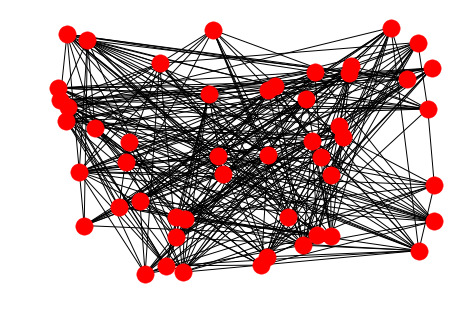

In [12]:
toy_data = generate_blau_data(num_samples=50)
print(toy_data['kernel'])

This is a very busy graph, with incidentally heterophilous weights, indicating that ties are formed between people who are further away in the Blau space. Now we can perform inference using either of the procedures: maximum a posteriori estimate (Adam) and mean of posterior samples (HMC). Since we already know the original kernel from which the data was generated, we can straightforwardly evaluate the inference results.

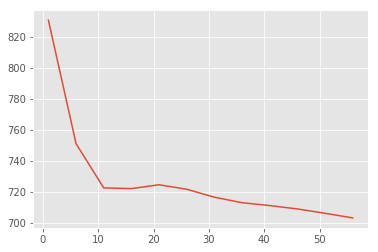

Original kernel: {'ed': -1.3754498, 'w': array([0.37281668, 0.6878397 ], dtype=float32), 'y': array([0, 0, 0, ..., 0, 1, 1], dtype=int32), 'c': 0.8636868}
MAP kernel: {'ed': -1.2718848, 'w': array([0.25562966, 0.43584025], dtype=float32), 'c': -0.39016923}


In [15]:
toy_adam = infer_kernel_adam(toy_data['coords'], net=toy_data['network'])
print('Original kernel:', toy_data['kernel'])
print('MAP kernel:', toy_adam)

We note that the NLL is being lowered with every iteration, and observe that the MAP estimates are fairly close to the original kernel. However, the estimate of $\gamma$ (given by `'c'` above) is way off. In fact, it shouldn't be negative, which indicates that the optimizer is possibly stuck in an unfavourable well of the landscape. One could consider running the optimizer for more number of iterations, or with a different initial point. Let us now employ HMC to obtain posterior samples of parameters.

acceptance rate: 0.879


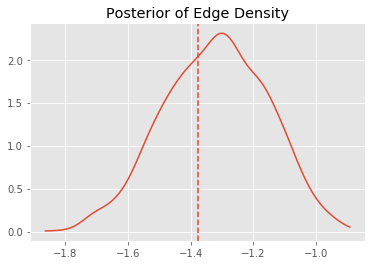

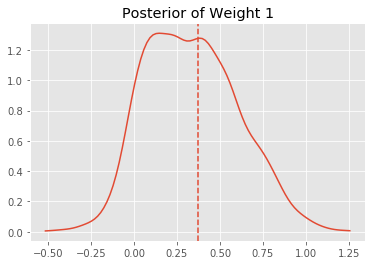

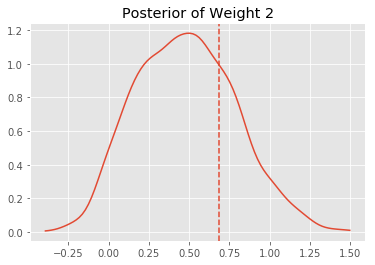

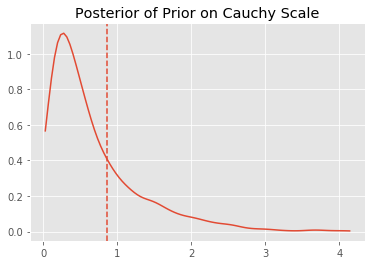

Original kernel: {'ed': -1.3754498, 'w': array([0.37281668, 0.6878397 ], dtype=float32), 'y': array([0, 0, 0, ..., 0, 1, 1], dtype=int32), 'c': 0.8636868}
Posterior mean kernel: {'ed': -1.3204534, 'w': array([0.3358189 , 0.47840583], dtype=float32), 'c': 0.6711324}


In [19]:
toy_hmc = infer_kernel_hmc(toy_data['coords'], net=toy_data['network'], kernel_orig=toy_data['kernel'])
print('Original kernel:', toy_data['kernel'])
print('Posterior mean kernel:', toy_hmc)

The posterior distributions have modes (and means) quite close to the original parameters of the kernel, including for $\gamma$. 

## Social Network Considerations
The above toy network is unlikely to be a "social" network. Let us make it into one.

### Sparse Homophilous Kernel
Clearly, it is unlikely that social networks would show heterophily as in the above example. Moreover, social networks are mostly very large and very sparse. Thus, let us generate data on a Blau space of $n=200$ people while selecting for a desired parametrization of $\phi=-1, \theta_1=-4, \theta_2=-8$ to make the network tightly homophilic while sparse. (Notice that conditioned on $\boldsymbol\theta$, $\gamma$ is independent of every other variable in the model. Thus, we could specify any $\gamma$ while obtaining the exact same observed data. This should highlight the fact that the posterior estimates of $\boldsymbol\theta$ and $\gamma$, given the data, are tied to one another.)

/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


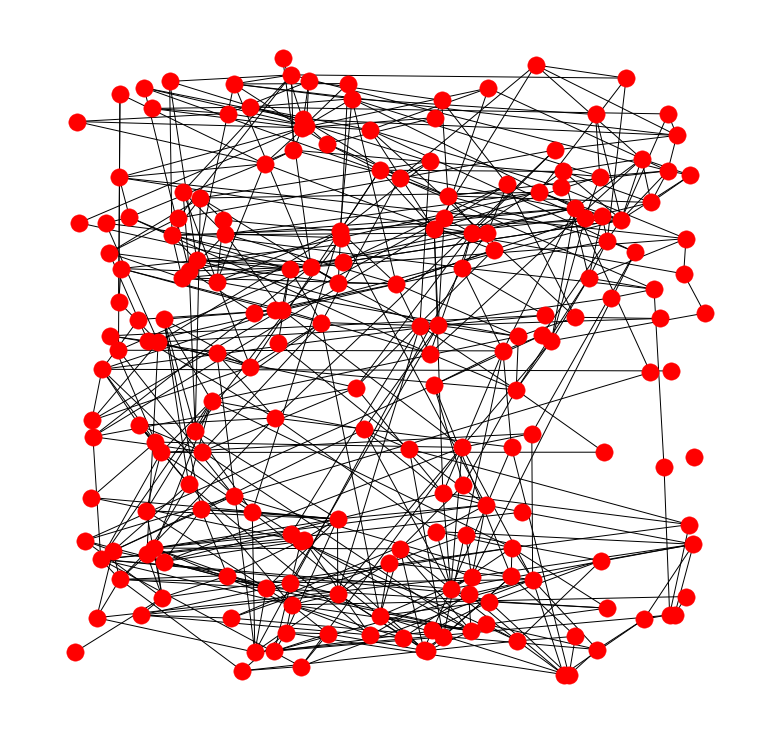

In [93]:
soc_data = generate_blau_data(num_samples=200, ed=-1, w=[-4,-8], c=1)

In [95]:
'''import pickle
with open('soc_data_200.pkl', 'wb') as fd:
    pickle.dump(soc_data, fd)'''

In [7]:
'''import pickle
with open('soc_data_200.pkl', 'rb') as fd:
    soc_data = pickle.load(fd)'''

### Network Subsampling

Moreover, in real-life, collecting social datasets of this form is particularly hard. Social surveys typically subsample a small $s$ number of people from the entire population of $n$, then ask them about their socio-demographics, and about those of $k$ of their friends. Thus, we observe only a partial network, with $s$ number of "seed" nodes, and a maximum of $ks$ number of "nominee" nodes and edges. Also, note that we do not obtain any information about "non-edges". However, assuming that the subsample is very small ($s\ll n$), it is very unlikely that two seeds would connect to one another, or to each other's nominees.

We would like to test the robustness of kernel inference under realistic social survey conditions. Correspondingly, we define a process to obtain a k-star sample of a network, where we ask every seed about a maximum `k_max` of their friends. Also, we must choose the number on "non-edges". For now, let us keep the same number of edges and "non-edges". (Since we will mostly be interested in conditional probability of edge *given* the kernel and location in Blau space, and never in the marginal probability of edges alone, this should not be an issue.)

In [8]:
def k_star_sample(train_data, k_max=3, k_min=1, num_seeds=None, noedge_ratio=1.0):
    #assumes undirected network
    from itertools import chain
    assert(k_max>=k_min)
    population_size = np.shape(train_data['network'])[0]
    node_selected = np.zeros(population_size)
    if num_seeds is None: num_seeds = int(np.sqrt(population_size))
    valid_population = np.arange(population_size)[np.sum(train_data['network'], axis=1)>=k_min] #subsample only those seeds which have at least k_min friends
    seeds_idx = np.random.permutation(valid_population)[0:num_seeds]
    edge_list = []
    nominee_set = set()
    for seed in seeds_idx:
        node_selected[seed] = 1
        valid_nominees = np.arange(population_size)[train_data['network'][seed,:]==1]
        nominees_idx = np.random.permutation(valid_nominees)[0:min(k_max, population_size)]
        edge_list += [[seed, nominee, 1] for nominee in nominees_idx if [nominee, seed, 1] not in edge_list] #to not double-count edges
        nominee_set.update(nominees_idx)
    nominee_set = list(nominee_set)
    non_edges = list(chain(*[[[i, j, 0] for j in seeds_idx if i<j] for i in seeds_idx]))
    non_edges += list(chain(*[[[i, j, 0] for j in nominee_set if [i,j,1] not in edge_list and [j,i,1] not in edge_list] for i in seeds_idx]))
    edge_list += np.random.permutation(non_edges)[0:min(len(non_edges), int(noedge_ratio*len(edge_list)))].tolist()
    G = train_data['graph'].copy()
    import networkx as nx
    nx.draw_networkx_nodes(G, pos=train_data['coords'], node_color=node_selected)
    nx.draw_networkx_edges(G, pos=train_data['coords'], edgelist=[(u,v) for (u,v,t) in edge_list], edge_color=['r' if t==0 else 'g' for (u,v,t) in edge_list], width=4)
    nx.draw_networkx_edges(G, pos=train_data['coords'], edgelist=G.edges(), style='dashed')
    plt.axis('off')
    plt.gcf().set_size_inches(10, 10)
    return edge_list

Let us sample 10% of the nodes as seeds. The corresponding network plot shows seeds as yellow nodes, their nominee edges in solid green, the assumed non-edges in solid red, and the original edges in dashed black. We'll follow this with an HMC based inference of the kernel.

/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


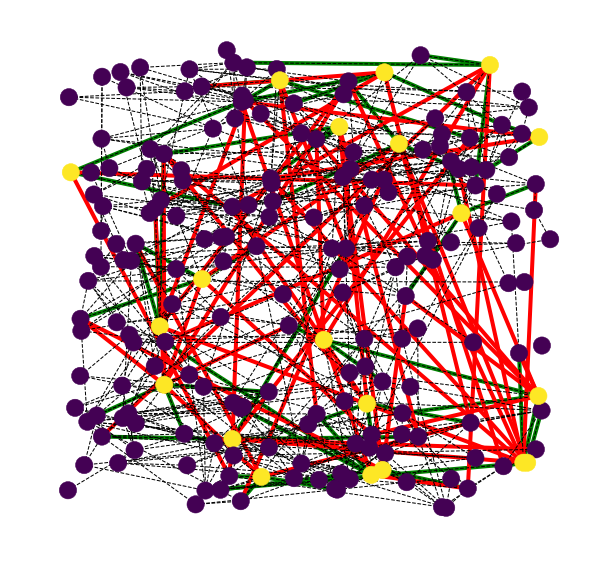

In [9]:
soc_sample = k_star_sample(soc_data, num_seeds=20)

acceptance rate: 0.9965


/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


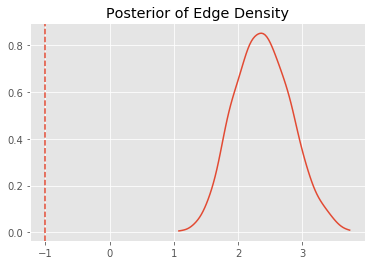

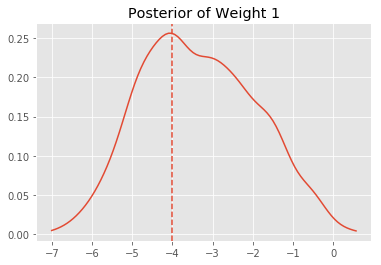

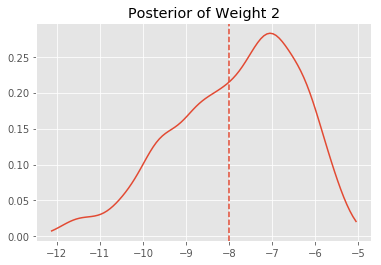

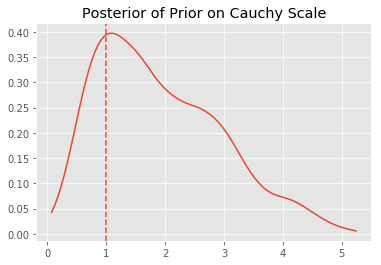

--On partially observed network--
Original kernel: {'ed': -1.0, 'w': array([-4., -8.], dtype=float32), 'y': array([0, 0, 1, ..., 0, 0, 0], dtype=int32), 'c': 1.0}
Posterior mean kernel: {'ed': 2.3869328, 'w': array([-3.3453736, -7.8246527], dtype=float32), 'c': 1.9166507}


In [10]:
soc_sample_hmc = infer_kernel_hmc(soc_data['coords'], edge_list=soc_sample, kernel_orig=soc_data['kernel'])
print('--On partially observed network--')
print('Original kernel:', soc_data['kernel'])
print('Posterior mean kernel:', soc_sample_hmc)

Clearly, the inferred kernel is very close in the true value of weight parameters $\boldsymbol\theta$. However, it is way off in the edge density $\phi$. This observation is apparent when we consider the role of $\phi$ as contributing to the probability of connection irrespective of node location. That is, assuming $\phi$ as the only source of contribution to connectivity, the degree of nodes would scale linearly with the number of nodes for a given $\phi$. For a subsampled network of size $s< n$, the same degree distribution can only be explained by a higher value of $\phi$. (Additionally, the edge non-edge ratio would decidedly affect the overall edge density as well.)

But as far as the parameters $\boldsymbol\theta$ of homophily are concerned, they should still be conserved. Since this is what we are mostly interested in for social analyses, this subsampling strategy works. However, how many seeds do we need for the estimates to be robust? Let us repeat the analysis with 5% seed nodes.

/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/rds/general/user/sl2416/home/anaconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


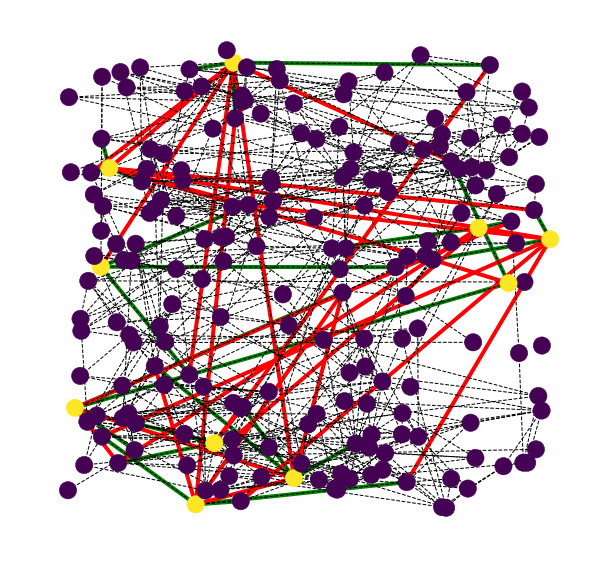

In [14]:
soc_sample_small = k_star_sample(soc_data, num_seeds=10)

acceptance rate: 0.9935


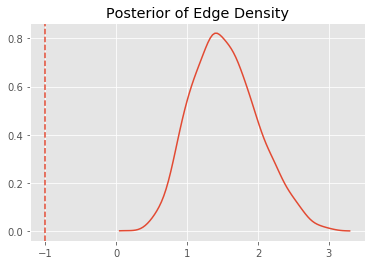

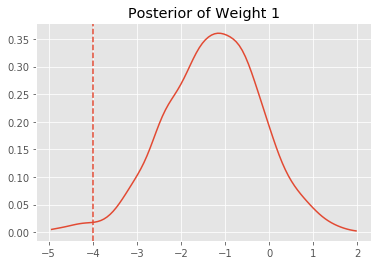

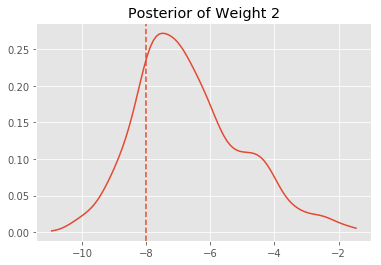

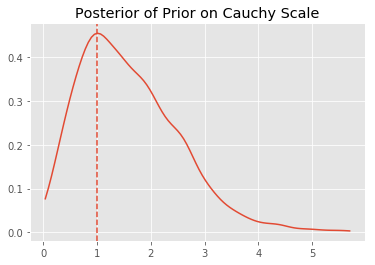

--On partially observed network--
Original kernel: {'ed': -1.0, 'w': array([-4., -8.], dtype=float32), 'y': array([0, 0, 1, ..., 0, 0, 0], dtype=int32), 'c': 1.0}
Posterior mean kernel: {'ed': 1.5351397, 'w': array([-1.2677735, -6.6752768], dtype=float32), 'c': 1.6003313}


In [15]:
soc_sample_small_hmc = infer_kernel_hmc(soc_data['coords'], edge_list=soc_sample_small, kernel_orig=soc_data['kernel'])
print('--On partially observed network--')
print('Original kernel:', soc_data['kernel'])
print('Posterior mean kernel:', soc_sample_small_hmc)

Although the inferred kernel still reflects the homophily of the original kernel, with the estimates on first dimension being larger-valued than the second, they are no longer close to the original kernel parameters. This is likely because we are approaching an underfit due to very few observed edges. (More robust checks needed, with much larger datasets where $n\approx 10^4-10^6$ and $s\approx 10^2-10^3$, with statistical confidences.)

## Statistics on the Inferred Kernel

Once we have inferred a connectivity kernel, we can extract interesting information by issuing appropriate queries. For instance, one can define a metric of social isolation (see Till's Thesis), where the uncertainties carry over thanks to the probabilistic nature of the kernel. One can define the pairwise isolation felt by $i$ from $j$ as the extent to which $j$ would prefer to form friendship with a person at identical Blau coordinates ($x_j$), versus with someone like $i$ (at $x_i$). This can be written as:
\begin{equation}
\psi(i,j)= -\log\frac{\rho_{ij}}{\rho_{jj}}
= \log\frac{\exp(\phi)+\exp(-\boldsymbol\theta^Tf_{ij})}{\exp(\phi)+1} \approx -\boldsymbol\theta^Tf_{ij} \quad\quad (\text{if } \phi \ll 0)
\end{equation}

Clearly, the isolation is more than 0 for a homophilous kernel, equal to 0 for an ambiphilous kernel, and less than 0 for a heterophilous kernel.
Furthermore, assuming that the prior distribution on node locations is uniform, we can integrate over all other nodes in the Blau space to quantify aggregate social segregation faced by $i$ in the society: $\widetilde{\psi(i)}=\sum_j \psi(i,j)$

In [19]:
def social_isolation(x, kernel, spins=None):
  """Calculates social isolation of points in a Blau space.
  
  Given a Logistic kernel and points in a Blau space, estimates pairwise 
  social isolation between all individuals in the space. Also "marginalizes"
  over to compute individual-level social isolation.
  
  Args:
    x (np.ndarray): a numpy matrix(nxd) representing n samples in a d
      dimensional Blau space
    kernel ((edge_density, weight)): a tuple of edge_density (scalar) and 
      weight (sequence/list of length equal to number of Blau dimensions)
    spins (np.ndarray): a numpy vector representing spin (+/-1) of the points
    
  Returns:
    separn (np.ndarray): a numpy matrix(nxn) representing pairwise separation
  """
  kernel = LogisticKernel(edge_density=kernel['ed'], weights=kernel['w'], 
                          feature_ndims=len(kernel['w']))
  intaxn = tf.stack([
      tf.stack([kernel.apply(x[i,:], x[j,:]) for j in range(x.shape[0])]) 
      for i in range(x.shape[0])], axis=0)
  with tf.Session() as sess:
    intaxn = sess.run(intaxn)
  separn = -1*np.log(intaxn/(np.diag(intaxn)[:,None]))
  separn_ind = np.sum(separn, axis=1)
  if spins is None:
    plt.scatter(x=x[:,0], y=x[:,1], c=separn_ind)
  else:
    plt.scatter(x=x[spins==1,0], y=x[spins==1,1], 
                c=separn_ind[spins==1], marker='+')
    plt.scatter(x=x[spins==-1,0], y=x[spins==-1,1], 
                c=separn_ind[spins==-1], marker='o')
  plt.colorbar()
  plt.axis('off')
  return separn 

Let us use the kernel we inferred from the subsampled network to quantify the total social segregation faced by each of the 200 individuals in the population.

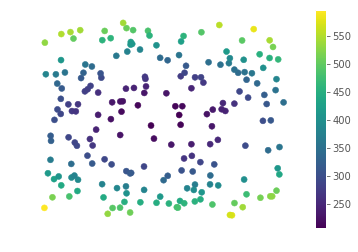

In [20]:
soc_seg = social_isolation(soc_data['coords'], soc_sample_hmc)

### WIP

In [9]:
def criticism(data, kernel):
  x = data['coords']  
  [num_samples, blau_dims] = x.shape
  y_true = tf.concat([tf.stack([data['network'][i,j] for j in range(i)]) 
                 for i in range(1, num_samples)], -1)
  ed = kernel['ed']
  w = kernel['w']
  kernel = LogisticKernel(edge_density=ed, weights=w, feature_ndims=blau_dims)
  y_prob = tf.concat([
      tf.stack([kernel.apply(x[i,:], x[j,:]) for j in range(i)]) 
      for i in range(1, num_samples)], -1)
  with tf.Session() as sess:
    [y_true, y_prob] = sess.run([y_true, y_prob])
  mean_cross_entropy = -np.mean(
      y_true*np.log(y_prob) + (1-y_true)*np.log(1-y_prob))
  print('mean cross entropy:', mean_cross_entropy)
  return mean_cross_entropy

In [49]:
def sensitivity_analysis(num_samples=50, num_runs=5, num_reps=1, hmc=False):
    train_data = generate_blau_data(num_samples=num_samples, c=1, ed=0.25, w=[-5,-10])
    print('overall edge density:', (1.0*np.sum(train_data['network']))/(num_samples*(num_samples-1)))
    print('original kernel:')
    print(train_data['kernel'])
    from itertools import chain
    edge_list = list(chain(*[[(i,j) for j in range(i)] for i in range(1, num_samples)]))
    conn_kernels = []
    for rep in range(num_reps):
        edge_list_shuffled = np.random.permutation(edge_list)
        edge_set_sz = int(len(edge_list)/(num_runs-1))
        conn_kernel = []
        for i in range(1,num_runs-1):
            print('run', i)
            data = edge_list_shuffled[0:i*edge_set_sz]
            if hmc: conn_kernel.append(infer_kernel_hmc(train_data['coords'], train_data['network'], data))
            else: conn_kernel.append(infer_kernel_adam(train_data['coords'], train_data['network'], data))
            print('predicted kernel:')
            print(conn_kernel[-1])
        print('final run')
        if hmc: conn_kernel.append(infer_kernel_hmc(train_data['coords'], train_data['network'], edge_list_shuffled))
        else: conn_kernel.append(infer_kernel_adam(train_data['coords'], train_data['network'], edge_list_shuffled))
        print('predicted kernel:')
        print(conn_kernel[-1])
        conn_kernels.append(conn_kernel)        
    return conn_kernels

In [ ]:
def opiniated_gaussian_mixtures(num_samples=50, num_components=3, 
                                mean_scale=[1., 4.], sigma_scale=1.,
                                ind_dim=True,
                                p_opinion=[0.9, 0.1, 0.5], p_component=None, 
                                dims=2, df=4, state=None):
  """Generates people in a Gaussian mixture Blau space. 
  """
  if not isinstance(mean_scale, list):
    mean_scale = [mean_scale for i in range(dims)]
  for s in mean_scale: assert(s>=0.)
  assert(len(mean_scale)==dims)
  
  if not isinstance(sigma_scale, list):
    sigma_scale = [sigma_scale for i in range(dims)]
  for s in sigma_scale: assert(s>=0.)
  assert(len(sigma_scale)==dims)
    
  if not isinstance(p_opinion, list):
    p_opinion = [p_opinion for i in range(num_components)]
  for p in p_opinion: assert(0.<=p<=1.)
  assert(len(p_opinion)==num_components)
  
  if p_component is None:
    p_component = [1./num_components for i in range(num_components)]
  for p in p_component: assert(0.<=p<=1.)
  assert(len(p_component)==num_components)
  assert(sum(p_component)==1)
  
  assert(df>=dims+1)
  
  import scipy.stats as stat
  component_means = np.transpose(
      np.vstack([stat.norm.rvs(scale=s, size=num_components, 
                               random_state=state) for s in mean_scale]))
  if ind_dim:
    component_vars = np.transpose(
        np.vstack([stat.gamma.rvs(a=s, size=num_components, 
                                  random_state=state) for s in sigma_scale]))
    component_vars = np.squeeze(np.stack(np.expand_dims(
        [np.diag(component_vars[i,:]) for i in range(component_vars.shape[0])], 
        axis=0)), axis=0)
  else:
    component_vars = stat.invwishart.rvs(df, np.diag(sigma_scale), 
                                         size=num_components)
  assignments = stat.multinomial.rvs(1, p_component, 
                                     size=num_samples, random_state=state)
  p_opinion_ = assignments.dot(p_opinion)
  assignments = np.nonzero(assignments)[1]
  opinions = 2*np.array([stat.bernoulli.rvs(p) for p in p_opinion_])-1
  
  points = np.array([stat.multivariate_normal.rvs(
      mean=component_means[i,:], cov=component_vars[i,:,:]) 
                    for i in assignments], dtype=np.float32)
  plt.scatter(x=points[opinions==1,0], y=points[opinions==1,1], 
              c=assignments[opinions==1], marker='+')
  plt.scatter(x=points[opinions==-1,0], y=points[opinions==-1,1], 
              c=assignments[opinions==-1], marker='o')
  return {'coords':points, 'spins':opinions, 'component':assignments, 
          'mean':component_means, 'covariance': component_vars}

In [6]:
def spins2net(spins):
  spins = tf.expand_dims(spins,-1)
  net = tf.cast((tf.matmul(spins, spins, transpose_b=True) + 1)/2, 
                   dtype=tf.int32)
  return net

In [ ]:
def prep_survey_data(survey_name='usoc', wave='c'):
  """Prepare data from surveys.
  
  alp: American Life Panel
  bhps: British Household Panel Survey
  usoc: Understanding Society
  gss: General Society Survey
  
  cf: for usoc
  """
  from google.colab import drive
  gdrive = '/content/gdrive'
  drive.mount(gdrive)
  import pandas as pd
  import os
  raw_data = pd.read_stata(os.path.join(
      gdrive, 'My Drive', 'survey_kernel_inference', 
      'understanding_society', '%s_indresp.dta' % wave),
                           convert_categoricals=False)
  return raw_data

### TO DO

1. Develop expanded USoc dataset class (multiple dims, health indicators, political attitudes, waves?)
2. METADAC proposal for using genome+USoc?